Module importieren

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from fitter import Fitter
import numpy as np
from scipy import stats
import statsmodels.api as sm
from tabulate import tabulate

Daten laden und säubern

In [18]:
def open_csv_to_df(directory):
    df = pd.read_csv(directory)
    df = df.iloc[0:,:4]
    df.columns = ["Date", "Time", "Mass_(kg)", "Velocity_(m/s)"]
    #df_energy = pd.DataFrame()
    df.insert(4, "Energy", "")
    df.insert(5, "Date_and_Time", "")
    df.insert(6, "Time_delta_(h)", "")
    for i in range(len(df)):
        df.iloc[i,4] = 0.5 * float(df.iloc[i,2]) * float(df.iloc[i,3]) ** 2 / 1000 #calculation of Energy
    df = df.sort_values(['Date', 'Time']).reset_index(drop=True)
    df = df.dropna()

    for i in range(len(df)):
        date_raw = df.iloc[i,:].Date +" " +df.iloc[i,:].Time
        date1 = datetime.strptime(date_raw, '%Y-%m-%d %H:%M')
        df.iloc[i,5] = date1

    for i in range(len(df)-1):
        date1 = df.iloc[i,5]
        date2 = df.iloc[i+1,5]
        time_delta = date2 - date1
        time_delta = (time_delta.days*24) + (time_delta.seconds//3600)
        df.iloc[i+1,6] = time_delta

    #Fitter kann keine NAs handhaben aus diesem Grund wird erste Beobachtung mit dem Median der Zeitabstände ersetzt.
    df.iloc[0,6] = 0
    df['Time_delta_(h)'] = df['Time_delta_(h)'].astype('int')
    df.iloc[0,6] = df["Time_delta_(h)"].median()

    return df #this is the table with all stones combined

In [19]:
df1 = open_csv_to_df("./out_1.csv")
df2 = open_csv_to_df("./out_2.csv")

,Date,Time,Mass_(kg),Velocity_(m/s),Energy,Date_and_Time,Time_delta_(h)
0,2019-01-01,09:00,194.0,8.4,6.84432,2019-01-01 09:00:00,22
1,2019-01-01,21:00,224.0,8.8,8.67328,2019-01-01 21:00:00,12
2,2019-01-02,14:00,3104.0,9.2,131.36128,2019-01-02 14:00:00,17
3,2019-01-04,15:00,228.0,8.0,7.296,2019-01-04 15:00:00,49
4,2019-01-05,23:00,755.0,7.0,18.4975,2019-01-05 23:00:00,32
...,...,...,...,...,...,...,...
63,2019-03-18,16:00,167.0,8.9,6.614035,2019-03-18 16:00:00,28
64,2019-03-22,18:00,2847.0,7.0,69.7515,2019-03-22 18:00:00,98
65,2019-03-26,00:00,44.0,8.9,1.74262,2019-03-26 00:00:00,78
66,2019-03-26,06:00,45.0,8.4,1.5876,2019-03-26 06:00:00,6


Funktion für Fitting von Verteilungen

In [21]:
def fit_distribution(data):
    count = 0
    fitted_mass = Fitter(data)
    fitted_mass.fit()
    ks_summary = fitted_mass.summary()
    distributions = ks_summary.index.values
    print(ks_summary.iloc[:,-2:])
    fig, ax = plt.subplots(1,5,figsize=(25, 5))
    table = [['Distribution', 'Parameters']]


    for i in distributions:
        param = fitted_mass.fitted_param[i]
        table.append([i, param])
        dist_eval = eval('stats.' + i + '.rvs(*param, size = 1000)')
        sm.qqplot_2samples(data, dist_eval, xlabel = i.capitalize() + ' Distribution', ylabel = 'Sample Distribution', line = '45' ,ax = ax[count])
        count += 1
    plt.show()
    print(tabulate(table, headers = 'firstrow'))

Zone 1

Fitting 109 distributions:  92%|█████████▏| 100/109 [00:40<00:09,  1.10s/it]C:\Users\nrech\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 109 distributions: 100%|██████████| 109/109 [01:03<00:00,  1.71it/s]
C:\Users\nrech\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, 

               ks_statistic  ks_pvalue
gennorm            0.262659   0.000125
nct                0.063312   0.931971
norminvgauss       0.054987   0.979261
genhyperbolic      0.055751   0.976320
invgamma           0.059734   0.956506


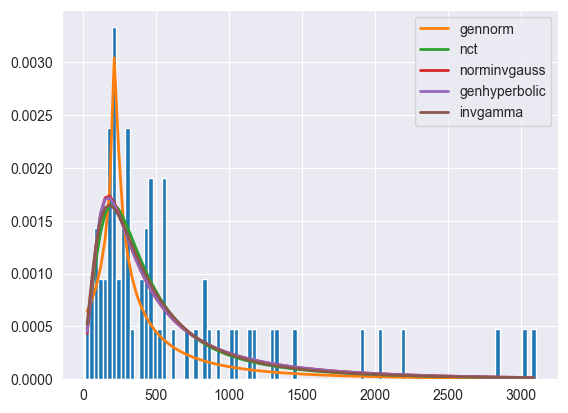

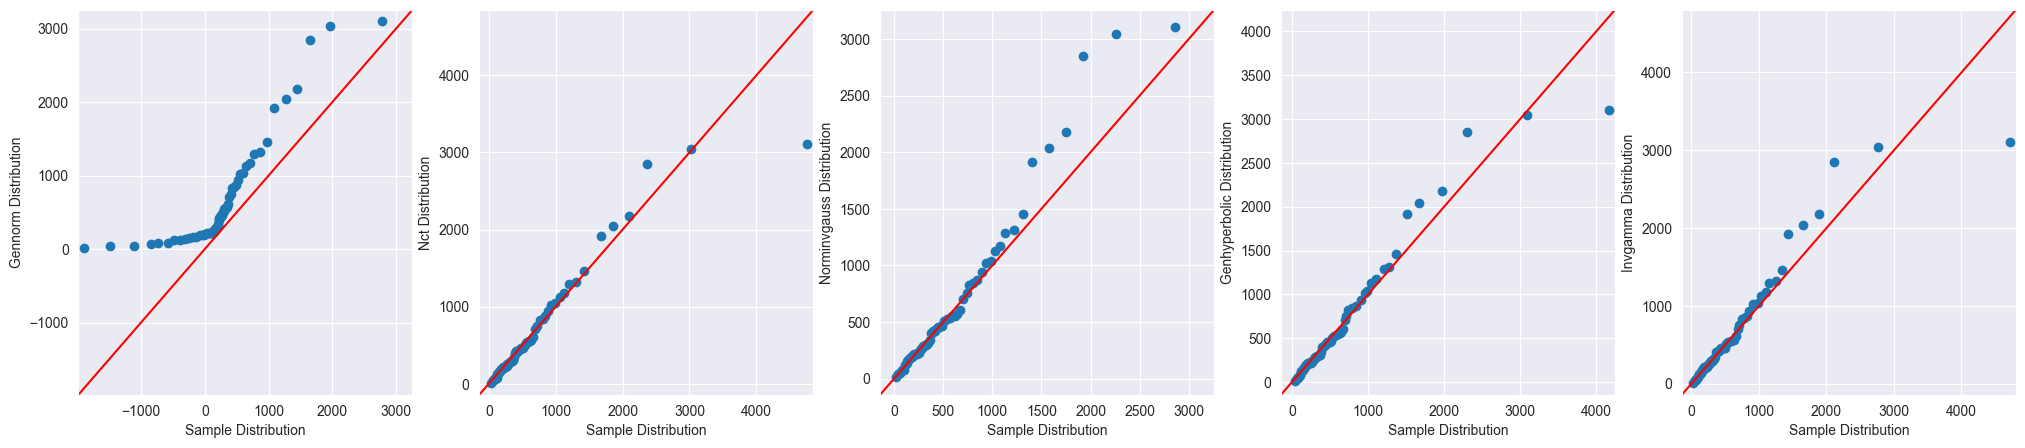

Distribution    Parameters
--------------  ---------------------------------------------------------------------------------------------------
gennorm         (0.4279160801639092, 219.99999994398019, 35.86654433090574)
nct             (1.7225348536963603, 3.7037541378718943, -114.50828494765057, 109.93539690382457)
norminvgauss    (3.1212660746620413, 3.049636729092045, 34.65446329649014, 129.49172019279249)
genhyperbolic   (-0.6161331856951546, 3.868715822305541, 3.8031427614177913, 17.26430842394451, 127.06396515473591)
invgamma        (2.15306844124149, -107.70820900423357, 901.310616335688)


In [8]:
#fit_distribution(df1['Mass_(kg)'])

In [ ]:
#fit_distribution(df1["Velocity_(m/s)"])

In [ ]:
#fit_distribution(df1["Time_delta_(h)"])

Zone 2

In [ ]:
#fit_distribution(df2['Mass_(kg)'])

Fitting 109 distributions:  37%|███▋      | 40/109 [00:10<00:22,  3.10it/s]C:\Users\nrech\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:3405: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t1 = integrate.quad(llc, -np.inf, x)[0]
Fitting 109 distributions:  91%|█████████ | 99/109 [00:34<00:09,  1.06it/s]C:\Users\nrech\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_out

           ks_statistic  ks_pvalue
triang         0.079567   0.977549
johnsonsb      0.078694   0.979807
argus          0.074869   0.987868
beta           0.074197   0.989000
skewnorm       0.111555   0.779976


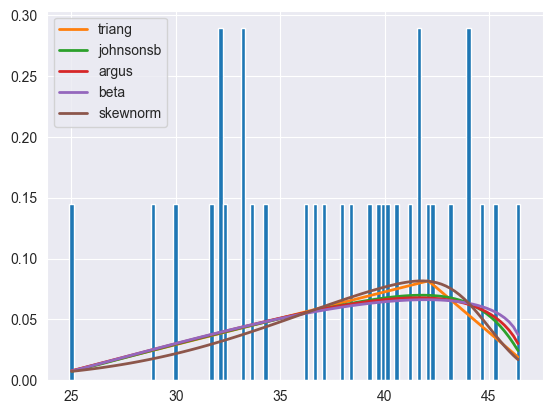

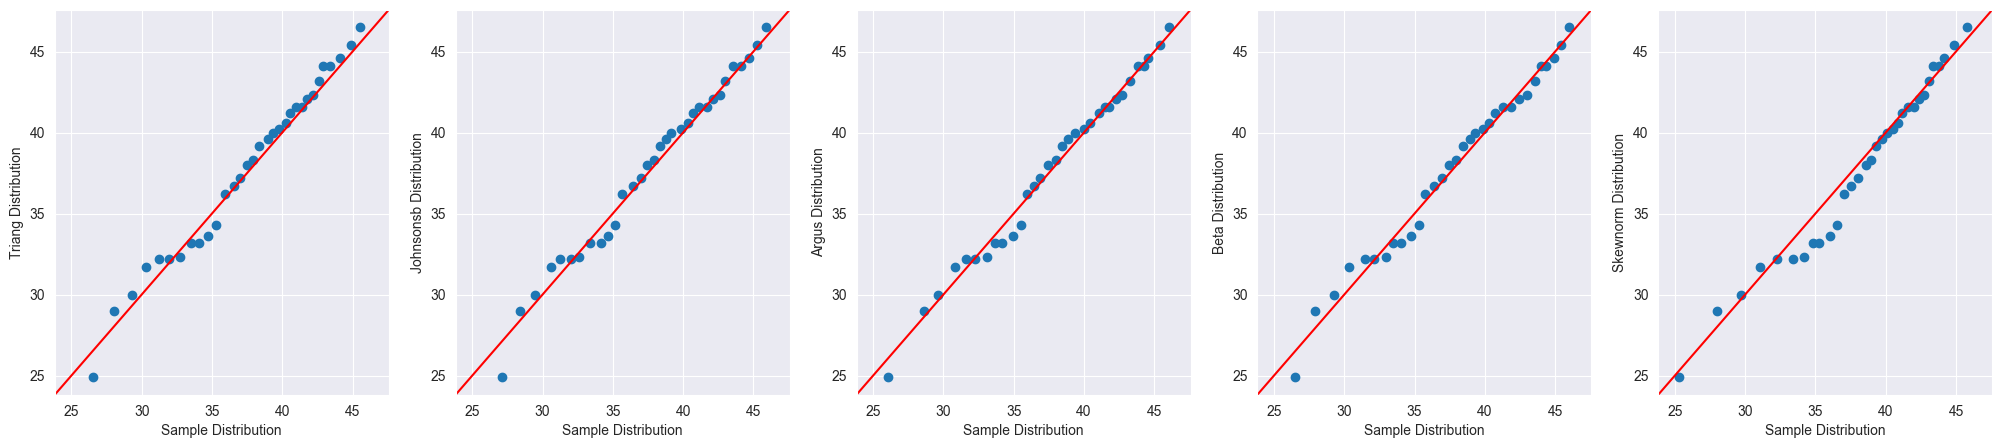

Distribution    Parameters
--------------  ---------------------------------------------------------------------------------
triang          (0.7712821853182876, 23.229908790827896, 24.46587196219638)
johnsonsb       (-0.5558603613471272, 0.9279041351963044, 22.024490438266007, 25.486067104168228)
argus           (0.9441392083611122, 23.279780568536218, 23.53433123913555)
beta            (2.135456049863241, 1.2827668923945292, 23.092130432299154, 23.56888476645474)
skewnorm        (-5.381045392227277, 44.94727890214405, 8.911917479878616)


In [20]:
#fit_distribution(df2["Velocity_(m/s)"])

Fitting 109 distributions:  37%|███▋      | 40/109 [00:03<00:06, 10.77it/s]WARNING:root:SKIPPED kstwo distribution (taking more than 30 seconds)
C:\Users\nrech\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_continuous_distns.py:3405: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t1 = integrate.quad(llc, -np.inf, x)[0]
Fitting 109 distributions:  91%|█████████ | 99/109 [00:31<00:13,  1.39s/it]C:\Users\nrech\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integr

            ks_statistic  ks_pvalue
mielke          0.133036   0.577047
chi             0.124432   0.659214
exponpow        0.111520   0.780292
beta            0.108391   0.807793
gausshyper      0.097584   0.891864


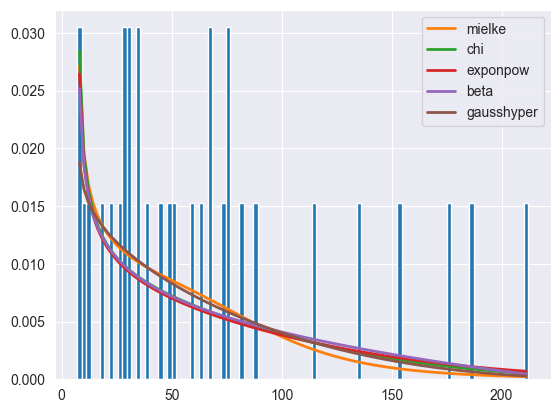

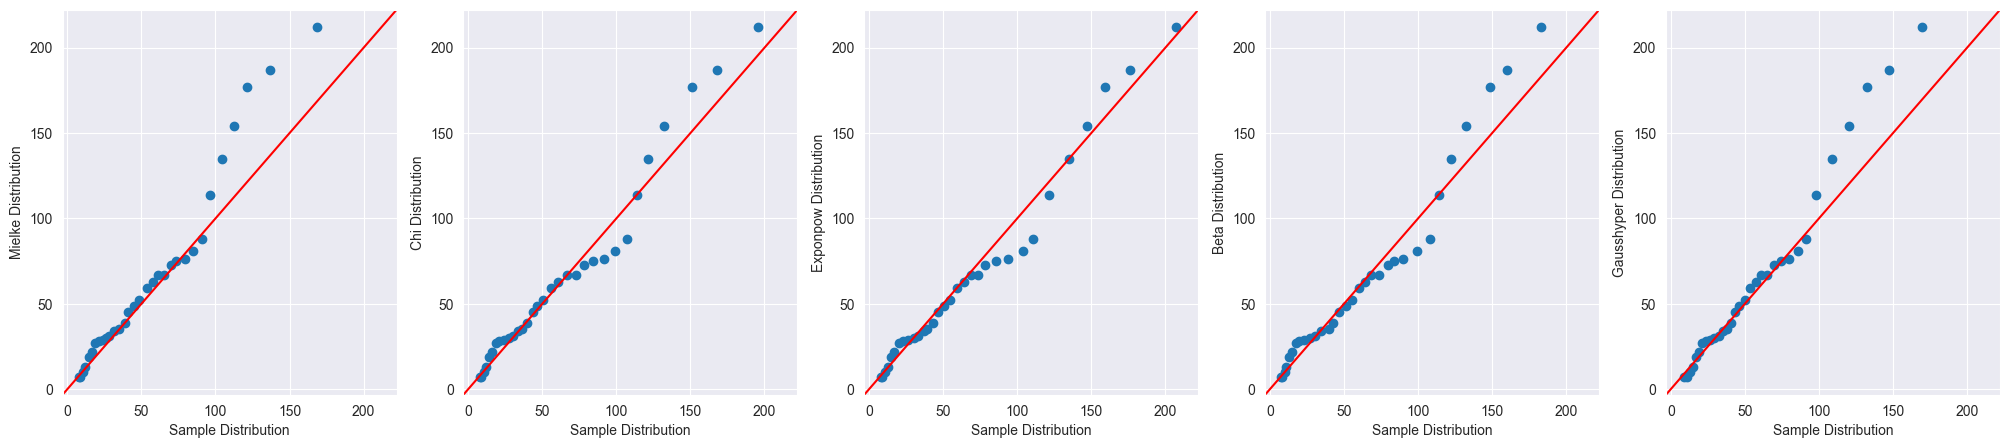

Distribution    Parameters
--------------  ----------------------------------------------------------------------------------------------------------------------
mielke          (0.7042718691767047, 3.727533457061383, 6.996913417646341, 100.55950873440945)
chi             (0.6596834499702577, 6.999999999999999, 97.32712708242903)
exponpow        (0.6869006970359615, 6.999999999999998, 113.2035691551996)
beta            (0.7251248885140398, 2.100362552610579, 6.999999999999999, 226.2588353675744)
gausshyper      (0.8978019324859241, 4.077276495962206, 1.307028041352496, -0.34508764303912354, 6.999999999999999, 279.0474036750189)


In [22]:
fit_distribution(df2["Time_delta_(h)"])

Monte Carlo

In [7]:
def plot_verteilung(dataframe, x_val):
    sns.set_style("white")
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)

Zone 1

In [10]:
mass1_sim = stats.norminvgauss.rvs(3.1212660746620413, 3.049636729092045, 34.65446329649014, 129.49172019279249, size = 10000)
df1_mass_sim = pd.DataFrame(mass1_sim)
#df1_mass_sim[df1_mass_sim[0] < 0][0]

361     -26.047539
710     -18.568947
840     -42.737206
983     -11.350812
1270    -37.718609
1612    -32.930723
1714     -5.133605
1753    -17.428893
2245    -21.687413
2592    -28.634556
2854    -75.134101
2971    -45.135184
3317    -20.453079
3602    -25.497328
3642     -1.571142
4059    -12.746866
4187    -37.032241
4262    -20.580961
4529    -26.843144
4610     -2.135936
5569     -4.002005
5586    -11.209887
5627    -41.936260
5708    -28.366562
5802     -0.354819
6050    -31.363527
6112   -101.359451
6564    -18.310348
6937     -4.034840
7189     -2.566354
7244     -1.475611
7799    -43.337894
7976    -23.491531
7988    -20.012924
8048     -6.704335
8069    -31.112667
8473     -4.000035
8496    -13.988527
8500    -11.600158
8564    -21.044568
9076    -29.778753
9318    -25.103038
9488    -15.082543
Name: 0, dtype: float64

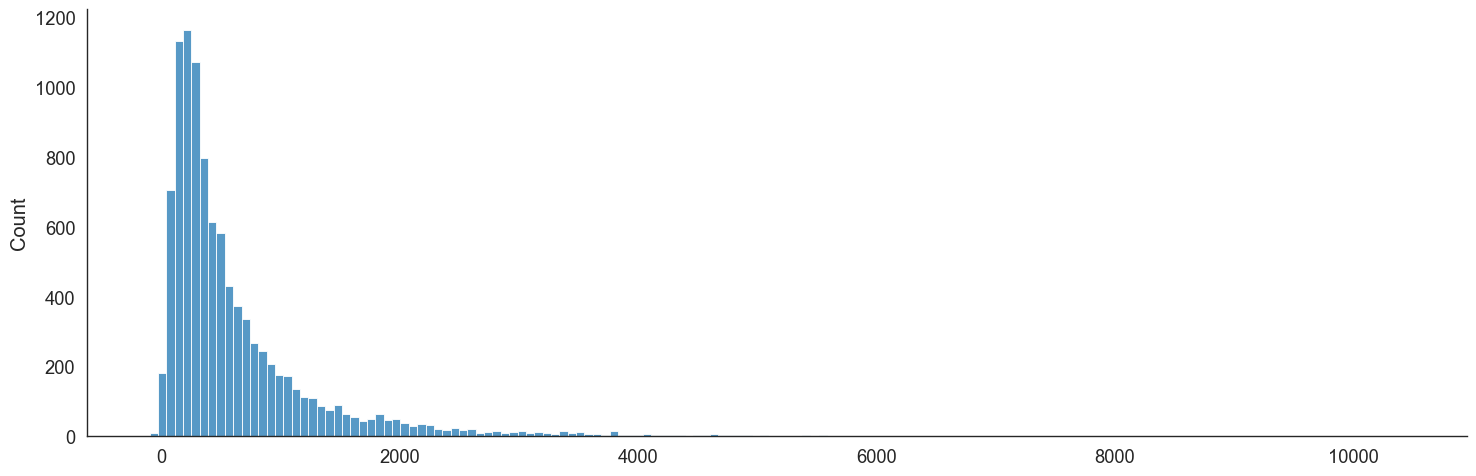

In [14]:
velocity1_sim = stats.norminvgauss.rvs(8.815229190843102, -1.1717104407578982, 9.56468292816113, 5.789676074259544, size = 10000)
df1_velocity_sim = pd.DataFrame(velocity1_sim)

In [30]:
timedelta1_sim = stats.chi.rvs(0.6466917035616518, -8.620646255400194e-27, 50.086113926689904, size = 1000000)
df1_timedelta_sim = pd.DataFrame(timedelta1_sim)

70222    -1.226924
222080   -0.303898
257837   -1.972782
258982   -0.545960
331851   -0.005800
534123   -0.377856
607148   -0.163086
640272   -0.447746
669719   -0.141922
891538   -0.384773
921184   -0.141020
959151   -0.709937
Name: 0, dtype: float64

Zone 2

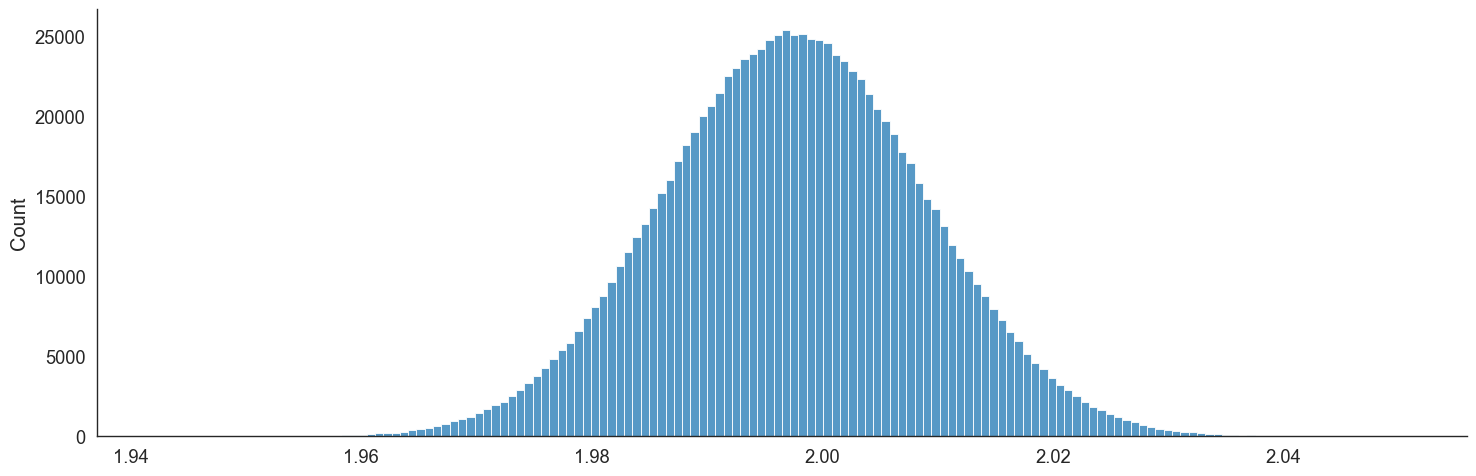

In [16]:
mass2_sim = stats.skewcauchy.rvs(0.5654845478523323, 31.009036433794673, 28.383685799048294, size = 1000000)
df2_mass_sim = pd.DataFrame(mass2_sim)

In [ ]:
velocity2_sim = stats.beta.rvs(2.135456049863241, 1.2827668923945292, 23.092130432299154, 23.56888476645474, size = 1000000)
df2_velocity_sim = pd.DataFrame(velocity2_sim)

In [1]:
timedelta2_sim = stats.expon.rvs(7.0, 59.322580645161295, size = 1000000)
df2_timedelta_sim = pd.DataFrame(timedelta2_sim)

NameError: name 'stats' is not defined